In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools
import pickle

import networkx as nx
import scipy

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

############################################################################################################################################################################################################################

## [1] Create Script to call all SNPs in a sample with Alternate AF $\ge 5 \%$ and pickle for downstream analysis

############################################################################################################################################################################################################################

In [3]:
%matplotlib inline

import vcf
import os
import pandas as pd
import numpy as np
from itertools import compress
import ast
import itertools
import time
import sys
import pickle
import shutil

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC
from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq

#### Import annotation files for all longitudinal samples

In [6]:
#annotation file for all isolates and corresponding tags
sample_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_fastq_path_names_and_JankyPipe_tags_filtered_final.csv' , sep = ',').set_index('patient_id')

#each sub-directory has the pilon-outputed VCF file, lineage call and Qualimap report
parent_output_dir = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/JankyPipe/output/'

In [7]:
sample_annotation.head()

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039337,NaN,1,ERR039337,serial
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039338,NaN,2,ERR039338,serial
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,NaN,Peru5115,1,Peru5115,serial
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,NaN,Peru4668,2,Peru4668,serial
2491,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,NaN,Peru4903,1,Peru4903,serial


### *Functions* to extract Base Calls

In [2]:
def Get_Base_Calls_from_VCF(tag , population , subject_id , timepoint_i):

    '''
    This function takes as input, the isolate tag, then extracts SINGLE base calls from
    the VCF file generated by Pilon. The function returns a DataFrame for a single isolate
    that contains [1] PASS calls that support the reference allele, [2] PASS calls that support
    an alternate allele and [3] AMB calls that support both the reference and alternate alleles.
    Note: Many base calls won't have an Alternate Allele.
    '''

    #directory where VCF file for sequenced isolated is stored & filename
    VCF_file = parent_output_dir + tag + '/pilon/' + tag + '.vcf'

    vcf_reader = vcf.Reader(open(VCF_file , 'r'))

    #position-base dictionaries
    base_order = {0:'A' , 1:'C' , 2:'G', 3:'T'} #order of output in Pilon
    base_order_r = {'A':0 , 'C':1 , 'G':2 , 'T':3}

    #create dictionaries to store information for each call
    ref_bases = {}
    qry_bases = {}
    ref_positions = {}
    quality_scores = {}
    SNP_type = {}
    PASS_filter = {}
    INFO_for_call = {}
    alt_allele_freq = {}
    valid_depth = {}

    #store the DEPTH of all base & variant calls (depth not stored for major structural variants)
    coverage_for_all_base_and_small_indel_calls = []

    #indexer for dataframe containing SNPs
    index = 0

    #iterate through each record from VCF file
    for record in vcf_reader:

        ######## store the DEPTH of all base & variant calls (depth not stored for major structural variants) ########
        try:
            coverage_for_all_base_and_small_indel_calls.append( record.INFO['DP'] )

        except KeyError: #major structural variant with no depth value
            pass 

        ######## Classify SNP-type according to Pilon Flags ########

        ### Filtering Criteria
        #---> Check that Filter is either PASS ([]) or AMBIGUOUS (['Amb']) , no 'DEL' or 'LOWCOV' flags from Pilon

        ### Call supporting REFERENCE
        #if there's no alternate allele and Filter is PASS; PASS call supporting Ref allele
        if (len(record.ALT) == 1) and (record.ALT == [None]) and (record.FILTER == []):

            alt_allele = 'Z' #no alternate allele supported by reads (might change through filtering process further down if small fraction of reads support an alternate)
            ref_allele = record.REF #allele on H37Rv
            SNP_type_for_Call = 'Ref_PASS'

        ### Call supporting ALTERNATE 
        #if there's 1 alternate allele, and Filter is PASS; PASS call supporting Alt allele
        elif (len(record.ALT) == 1) and (record.ALT != [None]) and (record.FILTER == []):

            alt_allele = str( record.ALT[0] ) #alternate allele supported by reads
            ref_allele = record.REF #allele on H37Rv
            SNP_type_for_Call = 'Alt_PASS'

        ### Call ambiguous between REFERNENCE and ALTERNATE
        #if there's 1 alternate allele, and Filter is AMB; AMB call supporting supporting neither Alt nor Ref
        elif (len(record.ALT) == 1) and (record.ALT != [None]) and (record.FILTER == ['Amb']):

            alt_allele = str( record.ALT[0] ) #alternate allele supported by reads
            ref_allele = record.REF #allele on H37Rv
            SNP_type_for_Call = 'Amb'

        ### Bad Quality Call, don't store information for this Base Call, move onto next
        else:

            continue

        ### Filtering Criteria (for Reference Confirmation or SNP)
        #---> Make sure that the length of all any alleles is 1 (No Variant or 1 Base) ; if variant, then variant is a SNP and not an INDEL
        if (len(ref_allele) == 1) and (len(alt_allele) == 1):

            ######## Retrieve Relevant information for filtering quality of Base Call ########

            # Mean Base Quality @ locus
            BQ = record.INFO['BQ']

            # Mean Mapping Quality @ locus
            MQ = record.INFO['MQ']

            # Number of Reads w/ Deletion 
            DC = record.INFO['DC']

            # Number of Reads w/ Insertion
            IC = record.INFO['IC']  

            ### Filtering Criteria
            #---> Mean Base Quality > 20
            #---> Mean Mapping Quality > 30
            #---> No Reads Supporting Insertions
            #---> No Reads Supporting Deletions
            if (BQ > 20) and (MQ > 30) and (DC == 0) and (IC == 0):

                # Quality-Percentage - Percentage of As, Cs, Gs, Ts weighted by Q & MQ at locus
                QP = record.INFO['QP']

                ### Filtering Criteria
                #---> Make sure that Reads support at most 2 alleles (either confirm the Reference or provide evidence for an alternate allele)
                #-----> If there are 2 alleles (make sure 1 of them is the Reference Allele)

                if (sum(np.array(QP) == 0) == 3): #1 Allele supported by Reads (either Reference or an Alternate), store information for this Base Call (3 bases have NO reads supporting)

                    #create a Boolean list for the Bases that have at least 1% of support from reads
                    supported_bases_boolean = list( np.array( QP ) > 0 )

                    #positions of Bases [A,C,G,T] with at least 1% of support from reads
                    supported_bases_i = [i for i,x in enumerate(supported_bases_boolean) if x == True] #returns list of length 
                    supported_base = base_order[supported_bases_i[0]]

                    #if the Reference Allele is supported
                    if supported_base == ref_allele:
                        alt_allele_frequency = 0.0 #no alternate allele

                    #if an Alternate Allele is supported:
                    if supported_base != ref_allele:
                        alt_allele_frequency = 1.0 #alternate allele

                elif (sum(np.array(QP) == 0) == 2): #2 Alleles supported, make sure 1 is the Reference & confirm the Alternate (2 bases have NO reads supporting)

                    #position of the Reference Allele in [A,C,G,T]
                    ref_allele_base_i = base_order_r[ref_allele] 

                    #create a Boolean list for the Bases that have at least 1% of support from reads
                    supported_bases_boolean = list( np.array( QP ) > 0 )

                    #positions of Bases [A,C,G,T] with at least 1% of support from reads
                    supported_bases_i = [i for i,x in enumerate(supported_bases_boolean) if x == True] #returns list of length 2

                    #check that Reference Allele is supported by at least 1% of the reads
                    if ref_allele_base_i in supported_bases_i:

                        #find the Alternate Allele that was supported by at least 1% of the reads
                        for supported_base_i in supported_bases_i:

                            if supported_base_i != ref_allele_base_i: #then must be alternate allele

                                alt_allele = base_order[supported_base_i] #Alternate Allele
                                alt_allele_frequency = float(QP[supported_base_i]) / 100.0 #weighted percentage of reads supporting Alternate Allele
                                break
                    
                    #Reference Allele is NOT supported by at least 1% of the reads (2 alleles supported but neither is the reference), don't store information for this Base Call
                    else:
                        continue

                #more than 2 alleles supported by reads, don't store information for this Base Call
                else: 
                    continue
                    
                #only store this base call if AF >= 5%
                if alt_allele_frequency >= 0.05:

                    #After extensive filtering and categorization, store all of the pertinent information about the Base Call
                    ref_bases[index] = ref_allele
                    qry_bases[index] = alt_allele
                    ref_positions[index] = record.POS
                    PASS_filter[index] = record.FILTER
                    quality_scores[index] = record.QUAL
                    SNP_type[index] = SNP_type_for_Call
                    INFO_for_call[index] = record.INFO
                    alt_allele_freq[index] = alt_allele_frequency
                    valid_depth[index] = record.INFO['DP']

                    index += 1

    #convert dictionaries to series
    ref_bases = pd.Series(ref_bases)
    qry_bases = pd.Series(qry_bases)
    ref_positions = pd.Series(ref_positions)
    quality_scores = pd.Series(quality_scores)
    SNP_type = pd.Series(SNP_type)
    PASS_filter = pd.Series(PASS_filter)
    INFO_for_call = pd.Series(INFO_for_call)
    alt_allele_freq = pd.Series(alt_allele_freq)
    valid_depth = pd.Series(valid_depth)
    tag_series = pd.Series([tag]*len(ref_bases.index) , index = ref_bases.index) #psuedo-series to store the tag id of the isolate

    #create DataFrame to hold all base calls for a given sample
    Variant_Call_DF = pd.DataFrame()
    Variant_Call_DF['ref_base'] = ref_bases
    Variant_Call_DF['alt_base'] = qry_bases
    Variant_Call_DF['ref_position'] = ref_positions
    Variant_Call_DF['quality'] = quality_scores
    Variant_Call_DF['SNP_type'] = SNP_type
    Variant_Call_DF['PASS_filter'] = PASS_filter
    Variant_Call_DF['INFO'] = INFO_for_call
    Variant_Call_DF['alt_AF'] = alt_allele_freq
    Variant_Call_DF['depth'] = valid_depth
    Variant_Call_DF['tag'] = tag_series

    ### Filtering Criteria (high coverage)
    #---> Filter out Base Calls with total # of reads aligning above the 99th percentile of covered positions in sample
    ninety_ninth_percentile_coverage = np.percentile( np.array( coverage_for_all_base_and_small_indel_calls ) , 99 )
    Variant_Call_DF = Variant_Call_DF[Variant_Call_DF.depth < ninety_ninth_percentile_coverage] #keep base calls that dont have unusually high coverage

    #reset index after dropping base calls with unusually high coverage
    Variant_Call_DF.reset_index(inplace = True , drop = True)
    
    ### Filtering Criteria (low coverage)
    #---> Filter out Base Calls with less than 25 reads covering Reference Position
    Variant_Call_DF = Variant_Call_DF[Variant_Call_DF.depth >= 25] #drop Base Calls with low coverage
    
    #reset index after dropping base calls with really low coverage
    Variant_Call_DF.reset_index(inplace = True , drop = True)
    
    #append psuedo-columns to note population & subject id
    population_series = pd.Series( [population] * np.shape(Variant_Call_DF)[0] , index = Variant_Call_DF.index )
    subject_id_series = pd.Series( [subject_id] * np.shape(Variant_Call_DF)[0] , index = Variant_Call_DF.index )

    Variant_Call_DF['population'] = population_series
    Variant_Call_DF['patient_id'] = subject_id_series
    
    #save single base call variants as a pickle
    Variant_Call_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/in_host_base_calls_above_5_AF/basecalls_timepoint_' + timepoint_i + '/' + tag + '_base_calls.pkl')

#### Call function above by specidying sample

In [ ]:
Get_Base_Calls_from_VCF(tag , population , subject_id , timepoint_i)

############################################################################################################################################################################################################################

## [2] Submit Jobs to call SNPs in each sample for longitudinal pairs

############################################################################################################################################################################################################################

In [7]:
import os
import pandas as pd
from slurmpy import Slurm
import numpy as np

#### Import annotation file for all patients

In [8]:
#annotation file for all isolates and corresponding tags
sample_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_fastq_path_names_and_JankyPipe_tags_filtered_final.csv' , sep = ',').set_index('patient_id')

In [9]:
sample_annotation.head()

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039337,NaN,1,ERR039337,longitudinal
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039338,NaN,2,ERR039338,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMJA00000000,Peru5115,1,Peru5115,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMPC00000000,Peru4668,2,Peru4668,longitudinal
2491,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMZT00000000,Peru4903,1,Peru4903,longitudinal


In [10]:
np.shape(sample_annotation) #200 subjects

(400, 7)

#### Import annotation for time between collection

In [11]:
time_between_collection_longitudinal_pairs_df = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/variant_calling/longitudinal_SNPs/number_SNPs_vs_time_per_patient.csv')
time_between_collection_longitudinal_pairs_df.set_index('Unnamed: 0' , inplace = True , drop = True) #sert index to longitudinal pair ID
time_between_collection_longitudinal_pairs_df = time_between_collection_longitudinal_pairs_df.loc[: , ['population' , 'time_between_collection']] #drop pairwise SNP distance

In [12]:
time_between_collection_longitudinal_pairs_df.head()

,population,time_between_collection
Unnamed: 0,,
2020E,BRYANT,8.40
2027W,BRYANT,11.20
2028K,BRYANT,6.07
2041Q,BRYANT,6.07
2043R,BRYANT,8.40


#### *Subset* patients to those that had date collection info

In [13]:
sample_annotation_subject_with_dates_filter = np.array([patient_id in  time_between_collection_longitudinal_pairs_df.index for patient_id in sample_annotation.index])

In [14]:
sample_annotation = sample_annotation[sample_annotation_subject_with_dates_filter]

In [15]:
np.shape(sample_annotation) #195 subjects with complete date information

(390, 7)

### Submit a job for each sample to get the SNPs called in the VCF

In [62]:
for sample_i in range(0 , np.shape(sample_annotation)[0]):
    
    sample_i_info = sample_annotation.iloc[sample_i , :]
    
    within_host_variants_job = 'python /n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/python_scripts/in_host_basecall_collection_AF_above_5.py ' + sample_i_info.tag + ' ' + sample_i_info.population + ' ' + sample_i_info.name + ' ' + str(sample_i_info.sample_order)

    #directory where you want output + error files
    os.chdir('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/in_host_base_calls_above_5_AF/O2_SLURM_logs/')

    job_name = str(sample_i)

    s = Slurm(job_name , {'partition':'short' , 'n':'1' , 't':'0-02:00:00' , 'mem-per-cpu':'16G' , 'mail-type':'FAIL' , 'mail-user':'roger_vargas@g.harvard.edu'})

    #submits the job
    job_id = s.run(within_host_variants_job)

    print job_name  + ' : ' +  str(job_id)

submitted: Submitted batch job 64349498
submitted: Submitted batch job 64349499
submitted: Submitted batch job 64349500


0 : 64349498
1 : 64349499
2 : 64349500


submitted: Submitted batch job 64349501
submitted: Submitted batch job 64349502
submitted: Submitted batch job 64349503


3 : 64349501
4 : 64349502
5 : 64349503


submitted: Submitted batch job 64349504
submitted: Submitted batch job 64349505
submitted: Submitted batch job 64349506


6 : 64349504
7 : 64349505
8 : 64349506


submitted: Submitted batch job 64349507
submitted: Submitted batch job 64349508
submitted: Submitted batch job 64349509


9 : 64349507
10 : 64349508
11 : 64349509


submitted: Submitted batch job 64349510
submitted: Submitted batch job 64349511
submitted: Submitted batch job 64349512


12 : 64349510
13 : 64349511
14 : 64349512


submitted: Submitted batch job 64349513
submitted: Submitted batch job 64349514
submitted: Submitted batch job 64349515


15 : 64349513
16 : 64349514
17 : 64349515


submitted: Submitted batch job 64349516


18 : 64349516


submitted: Submitted batch job 64349517
submitted: Submitted batch job 64349518
submitted: Submitted batch job 64349519


19 : 64349517
20 : 64349518
21 : 64349519


submitted: Submitted batch job 64349520
submitted: Submitted batch job 64349521


22 : 64349520
23 : 64349521


submitted: Submitted batch job 64349522
submitted: Submitted batch job 64349523
submitted: Submitted batch job 64349524


24 : 64349522
25 : 64349523
26 : 64349524


submitted: Submitted batch job 64349525
submitted: Submitted batch job 64349526
submitted: Submitted batch job 64349527


27 : 64349525
28 : 64349526
29 : 64349527


submitted: Submitted batch job 64349528
submitted: Submitted batch job 64349529
submitted: Submitted batch job 64349530


30 : 64349528
31 : 64349529
32 : 64349530


submitted: Submitted batch job 64349531
submitted: Submitted batch job 64349532


33 : 64349531
34 : 64349532


submitted: Submitted batch job 64349533
submitted: Submitted batch job 64349534
submitted: Submitted batch job 64349535


35 : 64349533
36 : 64349534
37 : 64349535


submitted: Submitted batch job 64349536
submitted: Submitted batch job 64349537
submitted: Submitted batch job 64349538


38 : 64349536
39 : 64349537
40 : 64349538


submitted: Submitted batch job 64349539
submitted: Submitted batch job 64349540
submitted: Submitted batch job 64349541


41 : 64349539
42 : 64349540
43 : 64349541


submitted: Submitted batch job 64349542


44 : 64349542


submitted: Submitted batch job 64349543
submitted: Submitted batch job 64349544
submitted: Submitted batch job 64349545


45 : 64349543
46 : 64349544
47 : 64349545


submitted: Submitted batch job 64349546
submitted: Submitted batch job 64349547
submitted: Submitted batch job 64349548


48 : 64349546
49 : 64349547
50 : 64349548


submitted: Submitted batch job 64349549
submitted: Submitted batch job 64349550


51 : 64349549
52 : 64349550


submitted: Submitted batch job 64349551
submitted: Submitted batch job 64349552
submitted: Submitted batch job 64349553


53 : 64349551
54 : 64349552
55 : 64349553


submitted: Submitted batch job 64349554
submitted: Submitted batch job 64349555
submitted: Submitted batch job 64349556


56 : 64349554
57 : 64349555
58 : 64349556


submitted: Submitted batch job 64349557
submitted: Submitted batch job 64349558


59 : 64349557
60 : 64349558


submitted: Submitted batch job 64349559
submitted: Submitted batch job 64349560
submitted: Submitted batch job 64349561


61 : 64349559
62 : 64349560
63 : 64349561


submitted: Submitted batch job 64349562
submitted: Submitted batch job 64349563
submitted: Submitted batch job 64349564
submitted: Submitted batch job 64349565


64 : 64349562
65 : 64349563
66 : 64349564
67 : 64349565


submitted: Submitted batch job 64349566


68 : 64349566


submitted: Submitted batch job 64349567
submitted: Submitted batch job 64349568
submitted: Submitted batch job 64349569


69 : 64349567
70 : 64349568
71 : 64349569


submitted: Submitted batch job 64349570
submitted: Submitted batch job 64349571
submitted: Submitted batch job 64349572


72 : 64349570
73 : 64349571
74 : 64349572


submitted: Submitted batch job 64349573
submitted: Submitted batch job 64349574
submitted: Submitted batch job 64349575
submitted: Submitted batch job 64349576


75 : 64349573
76 : 64349574
77 : 64349575
78 : 64349576


submitted: Submitted batch job 64349577
submitted: Submitted batch job 64349578


79 : 64349577
80 : 64349578


submitted: Submitted batch job 64349579
submitted: Submitted batch job 64349580
submitted: Submitted batch job 64349581


81 : 64349579
82 : 64349580
83 : 64349581


submitted: Submitted batch job 64349582
submitted: Submitted batch job 64349583
submitted: Submitted batch job 64349584
submitted: Submitted batch job 64349585


84 : 64349582
85 : 64349583
86 : 64349584
87 : 64349585


submitted: Submitted batch job 64349586
submitted: Submitted batch job 64349587
submitted: Submitted batch job 64349588


88 : 64349586
89 : 64349587
90 : 64349588


submitted: Submitted batch job 64349589
submitted: Submitted batch job 64349590


91 : 64349589
92 : 64349590


submitted: Submitted batch job 64349591
submitted: Submitted batch job 64349592
submitted: Submitted batch job 64349593


93 : 64349591
94 : 64349592
95 : 64349593


submitted: Submitted batch job 64349594
submitted: Submitted batch job 64349595


96 : 64349594
97 : 64349595


submitted: Submitted batch job 64349596
submitted: Submitted batch job 64349597
submitted: Submitted batch job 64349598


98 : 64349596
99 : 64349597
100 : 64349598


submitted: Submitted batch job 64349599
submitted: Submitted batch job 64349600


101 : 64349599
102 : 64349600


submitted: Submitted batch job 64349601
submitted: Submitted batch job 64349602
submitted: Submitted batch job 64349603


103 : 64349601
104 : 64349602
105 : 64349603


submitted: Submitted batch job 64349604
submitted: Submitted batch job 64349605
submitted: Submitted batch job 64349606


106 : 64349604
107 : 64349605
108 : 64349606


submitted: Submitted batch job 64349607
submitted: Submitted batch job 64349608


109 : 64349607
110 : 64349608


submitted: Submitted batch job 64349609


111 : 64349609


submitted: Submitted batch job 64349610
submitted: Submitted batch job 64349611
submitted: Submitted batch job 64349612


112 : 64349610
113 : 64349611
114 : 64349612


submitted: Submitted batch job 64349613
submitted: Submitted batch job 64349614
submitted: Submitted batch job 64349615


115 : 64349613
116 : 64349614
117 : 64349615


submitted: Submitted batch job 64349616
submitted: Submitted batch job 64349617


118 : 64349616
119 : 64349617


submitted: Submitted batch job 64349618
submitted: Submitted batch job 64349619
submitted: Submitted batch job 64349620


120 : 64349618
121 : 64349619
122 : 64349620


submitted: Submitted batch job 64349621
submitted: Submitted batch job 64349622


123 : 64349621
124 : 64349622


submitted: Submitted batch job 64349623
submitted: Submitted batch job 64349624
submitted: Submitted batch job 64349625


125 : 64349623
126 : 64349624
127 : 64349625


submitted: Submitted batch job 64349626


128 : 64349626


submitted: Submitted batch job 64349627
submitted: Submitted batch job 64349628
submitted: Submitted batch job 64349629


129 : 64349627
130 : 64349628
131 : 64349629


submitted: Submitted batch job 64349630
submitted: Submitted batch job 64349631
submitted: Submitted batch job 64349632


132 : 64349630
133 : 64349631
134 : 64349632


submitted: Submitted batch job 64349633
submitted: Submitted batch job 64349634
submitted: Submitted batch job 64349635


135 : 64349633
136 : 64349634
137 : 64349635


submitted: Submitted batch job 64349636
submitted: Submitted batch job 64349637


138 : 64349636
139 : 64349637


submitted: Submitted batch job 64349638
submitted: Submitted batch job 64349639
submitted: Submitted batch job 64349640


140 : 64349638
141 : 64349639
142 : 64349640


submitted: Submitted batch job 64349641
submitted: Submitted batch job 64349642
submitted: Submitted batch job 64349643


143 : 64349641
144 : 64349642
145 : 64349643


submitted: Submitted batch job 64349644
submitted: Submitted batch job 64349645
submitted: Submitted batch job 64349646


146 : 64349644
147 : 64349645
148 : 64349646


submitted: Submitted batch job 64349647
submitted: Submitted batch job 64349648


149 : 64349647
150 : 64349648


submitted: Submitted batch job 64349649
submitted: Submitted batch job 64349650
submitted: Submitted batch job 64349651


151 : 64349649
152 : 64349650
153 : 64349651


submitted: Submitted batch job 64349652
submitted: Submitted batch job 64349653
submitted: Submitted batch job 64349654


154 : 64349652
155 : 64349653
156 : 64349654


submitted: Submitted batch job 64349655
submitted: Submitted batch job 64349656


157 : 64349655
158 : 64349656


submitted: Submitted batch job 64349657


159 : 64349657


submitted: Submitted batch job 64349658
submitted: Submitted batch job 64349659
submitted: Submitted batch job 64349660


160 : 64349658
161 : 64349659
162 : 64349660


submitted: Submitted batch job 64349661
submitted: Submitted batch job 64349662
submitted: Submitted batch job 64349663


163 : 64349661
164 : 64349662
165 : 64349663


submitted: Submitted batch job 64349664


166 : 64349664


submitted: Submitted batch job 64349665
submitted: Submitted batch job 64349666
submitted: Submitted batch job 64349667


167 : 64349665
168 : 64349666
169 : 64349667


submitted: Submitted batch job 64349668
submitted: Submitted batch job 64349669
submitted: Submitted batch job 64349670


170 : 64349668
171 : 64349669
172 : 64349670


submitted: Submitted batch job 64349671
submitted: Submitted batch job 64349672
submitted: Submitted batch job 64349673


173 : 64349671
174 : 64349672
175 : 64349673


submitted: Submitted batch job 64349674


176 : 64349674


submitted: Submitted batch job 64349675
submitted: Submitted batch job 64349676
submitted: Submitted batch job 64349677


177 : 64349675
178 : 64349676
179 : 64349677


submitted: Submitted batch job 64349678
submitted: Submitted batch job 64349679
submitted: Submitted batch job 64349680
submitted: Submitted batch job 64349681


180 : 64349678
181 : 64349679
182 : 64349680
183 : 64349681


submitted: Submitted batch job 64349682
submitted: Submitted batch job 64349683
submitted: Submitted batch job 64349685


184 : 64349682
185 : 64349683
186 : 64349685


submitted: Submitted batch job 64349686
submitted: Submitted batch job 64349687


187 : 64349686
188 : 64349687


submitted: Submitted batch job 64349688
submitted: Submitted batch job 64349689
submitted: Submitted batch job 64349690


189 : 64349688
190 : 64349689
191 : 64349690


submitted: Submitted batch job 64349691
submitted: Submitted batch job 64349692
submitted: Submitted batch job 64349693


192 : 64349691
193 : 64349692
194 : 64349693


submitted: Submitted batch job 64349694
submitted: Submitted batch job 64349695
submitted: Submitted batch job 64349696
submitted: Submitted batch job 64349697


195 : 64349694
196 : 64349695
197 : 64349696
198 : 64349697


submitted: Submitted batch job 64349698


199 : 64349698


submitted: Submitted batch job 64349699
submitted: Submitted batch job 64349700
submitted: Submitted batch job 64349701


200 : 64349699
201 : 64349700
202 : 64349701


submitted: Submitted batch job 64349702
submitted: Submitted batch job 64349703
submitted: Submitted batch job 64349704


203 : 64349702
204 : 64349703
205 : 64349704


submitted: Submitted batch job 64349705
submitted: Submitted batch job 64349706


206 : 64349705
207 : 64349706


submitted: Submitted batch job 64349707


208 : 64349707


submitted: Submitted batch job 64349709
submitted: Submitted batch job 64349710


209 : 64349709
210 : 64349710


submitted: Submitted batch job 64349711
submitted: Submitted batch job 64349712


211 : 64349711
212 : 64349712


submitted: Submitted batch job 64349713
submitted: Submitted batch job 64349714
submitted: Submitted batch job 64349715


213 : 64349713
214 : 64349714
215 : 64349715


submitted: Submitted batch job 64349716
submitted: Submitted batch job 64349717
submitted: Submitted batch job 64349718


216 : 64349716
217 : 64349717
218 : 64349718


submitted: Submitted batch job 64349719
submitted: Submitted batch job 64349720
submitted: Submitted batch job 64349721


219 : 64349719
220 : 64349720
221 : 64349721


submitted: Submitted batch job 64349722


222 : 64349722


submitted: Submitted batch job 64349723


223 : 64349723


submitted: Submitted batch job 64349724
submitted: Submitted batch job 64349725
submitted: Submitted batch job 64349726


224 : 64349724
225 : 64349725
226 : 64349726


submitted: Submitted batch job 64349727
submitted: Submitted batch job 64349728


227 : 64349727
228 : 64349728


submitted: Submitted batch job 64349729
submitted: Submitted batch job 64349730
submitted: Submitted batch job 64349731


229 : 64349729
230 : 64349730
231 : 64349731


submitted: Submitted batch job 64349732
submitted: Submitted batch job 64349733


232 : 64349732
233 : 64349733


submitted: Submitted batch job 64349734
submitted: Submitted batch job 64349735
submitted: Submitted batch job 64349736


234 : 64349734
235 : 64349735
236 : 64349736


submitted: Submitted batch job 64349737
submitted: Submitted batch job 64349738


237 : 64349737
238 : 64349738


submitted: Submitted batch job 64349739
submitted: Submitted batch job 64349740
submitted: Submitted batch job 64349741


239 : 64349739
240 : 64349740
241 : 64349741


submitted: Submitted batch job 64349742
submitted: Submitted batch job 64349743
submitted: Submitted batch job 64349744


242 : 64349742
243 : 64349743
244 : 64349744


submitted: Submitted batch job 64349745
submitted: Submitted batch job 64349746
submitted: Submitted batch job 64349747


245 : 64349745
246 : 64349746
247 : 64349747


submitted: Submitted batch job 64349748


248 : 64349748


submitted: Submitted batch job 64349749
submitted: Submitted batch job 64349750
submitted: Submitted batch job 64349751


249 : 64349749
250 : 64349750
251 : 64349751


submitted: Submitted batch job 64349752
submitted: Submitted batch job 64349753
submitted: Submitted batch job 64349754


252 : 64349752
253 : 64349753
254 : 64349754


submitted: Submitted batch job 64349755
submitted: Submitted batch job 64349756


255 : 64349755
256 : 64349756


submitted: Submitted batch job 64349757
submitted: Submitted batch job 64349758
submitted: Submitted batch job 64349759


257 : 64349757
258 : 64349758
259 : 64349759


submitted: Submitted batch job 64349760
submitted: Submitted batch job 64349761
submitted: Submitted batch job 64349762


260 : 64349760
261 : 64349761
262 : 64349762


submitted: Submitted batch job 64349763
submitted: Submitted batch job 64349764


263 : 64349763
264 : 64349764


submitted: Submitted batch job 64349765
submitted: Submitted batch job 64349766
submitted: Submitted batch job 64349767


265 : 64349765
266 : 64349766
267 : 64349767


submitted: Submitted batch job 64349768
submitted: Submitted batch job 64349769
submitted: Submitted batch job 64349770


268 : 64349768
269 : 64349769
270 : 64349770


submitted: Submitted batch job 64349771
submitted: Submitted batch job 64349772
submitted: Submitted batch job 64349773


271 : 64349771
272 : 64349772
273 : 64349773


submitted: Submitted batch job 64349774
submitted: Submitted batch job 64349775
submitted: Submitted batch job 64349776


274 : 64349774
275 : 64349775
276 : 64349776


submitted: Submitted batch job 64349777
submitted: Submitted batch job 64349778


277 : 64349777
278 : 64349778


submitted: Submitted batch job 64349779
submitted: Submitted batch job 64349780
submitted: Submitted batch job 64349781


279 : 64349779
280 : 64349780
281 : 64349781


submitted: Submitted batch job 64349782
submitted: Submitted batch job 64349783
submitted: Submitted batch job 64349784


282 : 64349782
283 : 64349783
284 : 64349784


submitted: Submitted batch job 64349785
submitted: Submitted batch job 64349786
submitted: Submitted batch job 64349787


285 : 64349785
286 : 64349786
287 : 64349787


submitted: Submitted batch job 64349788
submitted: Submitted batch job 64349789
submitted: Submitted batch job 64349790


288 : 64349788
289 : 64349789
290 : 64349790


submitted: Submitted batch job 64349791
submitted: Submitted batch job 64349792
submitted: Submitted batch job 64349793


291 : 64349791
292 : 64349792
293 : 64349793


submitted: Submitted batch job 64349794
submitted: Submitted batch job 64349795


294 : 64349794
295 : 64349795


submitted: Submitted batch job 64349796


296 : 64349796


submitted: Submitted batch job 64349797
submitted: Submitted batch job 64349798
submitted: Submitted batch job 64349799


297 : 64349797
298 : 64349798
299 : 64349799


submitted: Submitted batch job 64349800
submitted: Submitted batch job 64349801
submitted: Submitted batch job 64349802


300 : 64349800
301 : 64349801
302 : 64349802


submitted: Submitted batch job 64349803


303 : 64349803


submitted: Submitted batch job 64349804
submitted: Submitted batch job 64349805
submitted: Submitted batch job 64349806


304 : 64349804
305 : 64349805
306 : 64349806


submitted: Submitted batch job 64349807
submitted: Submitted batch job 64349808
submitted: Submitted batch job 64349809


307 : 64349807
308 : 64349808
309 : 64349809


submitted: Submitted batch job 64349810
submitted: Submitted batch job 64349811
submitted: Submitted batch job 64349812


310 : 64349810
311 : 64349811
312 : 64349812


submitted: Submitted batch job 64349813
submitted: Submitted batch job 64349814
submitted: Submitted batch job 64349815


313 : 64349813
314 : 64349814
315 : 64349815


submitted: Submitted batch job 64349816
submitted: Submitted batch job 64349817
submitted: Submitted batch job 64349818


316 : 64349816
317 : 64349817
318 : 64349818


submitted: Submitted batch job 64349819
submitted: Submitted batch job 64349820
submitted: Submitted batch job 64349821


319 : 64349819
320 : 64349820
321 : 64349821


submitted: Submitted batch job 64349822
submitted: Submitted batch job 64349823


322 : 64349822
323 : 64349823


submitted: Submitted batch job 64349824
submitted: Submitted batch job 64349825
submitted: Submitted batch job 64349826


324 : 64349824
325 : 64349825
326 : 64349826


submitted: Submitted batch job 64349827
submitted: Submitted batch job 64349828
submitted: Submitted batch job 64349829


327 : 64349827
328 : 64349828
329 : 64349829


submitted: Submitted batch job 64349830
submitted: Submitted batch job 64349831
submitted: Submitted batch job 64349832
submitted: Submitted batch job 64349833


330 : 64349830
331 : 64349831
332 : 64349832
333 : 64349833


submitted: Submitted batch job 64349834


334 : 64349834


submitted: Submitted batch job 64349835
submitted: Submitted batch job 64349836
submitted: Submitted batch job 64349837


335 : 64349835
336 : 64349836
337 : 64349837


submitted: Submitted batch job 64349838
submitted: Submitted batch job 64349839
submitted: Submitted batch job 64349840
submitted: Submitted batch job 64349841


338 : 64349838
339 : 64349839
340 : 64349840
341 : 64349841


submitted: Submitted batch job 64349842
submitted: Submitted batch job 64349843


342 : 64349842
343 : 64349843


submitted: Submitted batch job 64349844


344 : 64349844


submitted: Submitted batch job 64349845


345 : 64349845


submitted: Submitted batch job 64349846


346 : 64349846


submitted: Submitted batch job 64349847
submitted: Submitted batch job 64349848
submitted: Submitted batch job 64349849


347 : 64349847
348 : 64349848
349 : 64349849


submitted: Submitted batch job 64349850


350 : 64349850


submitted: Submitted batch job 64349851


351 : 64349851


submitted: Submitted batch job 64349852


352 : 64349852


submitted: Submitted batch job 64349853


353 : 64349853


submitted: Submitted batch job 64349855
submitted: Submitted batch job 64349856


354 : 64349855
355 : 64349856


submitted: Submitted batch job 64349857


356 : 64349857


submitted: Submitted batch job 64349860


357 : 64349860


submitted: Submitted batch job 64349861
submitted: Submitted batch job 64349862


358 : 64349861
359 : 64349862


submitted: Submitted batch job 64349863


360 : 64349863


submitted: Submitted batch job 64349864
submitted: Submitted batch job 64349865
submitted: Submitted batch job 64349866


361 : 64349864
362 : 64349865
363 : 64349866


submitted: Submitted batch job 64349867
submitted: Submitted batch job 64349868


364 : 64349867
365 : 64349868


submitted: Submitted batch job 64349869
submitted: Submitted batch job 64349870
submitted: Submitted batch job 64349871


366 : 64349869
367 : 64349870
368 : 64349871


submitted: Submitted batch job 64349872
submitted: Submitted batch job 64349873


369 : 64349872
370 : 64349873


submitted: Submitted batch job 64349874
submitted: Submitted batch job 64349875
submitted: Submitted batch job 64349876


371 : 64349874
372 : 64349875
373 : 64349876


submitted: Submitted batch job 64349877
submitted: Submitted batch job 64349878
submitted: Submitted batch job 64349879
submitted: Submitted batch job 64349880


374 : 64349877
375 : 64349878
376 : 64349879
377 : 64349880


submitted: Submitted batch job 64349881
submitted: Submitted batch job 64349882
submitted: Submitted batch job 64349883
submitted: Submitted batch job 64349884


378 : 64349881
379 : 64349882
380 : 64349883
381 : 64349884


submitted: Submitted batch job 64349885
submitted: Submitted batch job 64349886


382 : 64349885
383 : 64349886


submitted: Submitted batch job 64349887
submitted: Submitted batch job 64349888
submitted: Submitted batch job 64349889


384 : 64349887
385 : 64349888
386 : 64349889
387 : 64349890
388 : 64349891
389 : 64349892


submitted: Submitted batch job 64349890
submitted: Submitted batch job 64349891
submitted: Submitted batch job 64349892


############################################################################################################################################################################################################################

## [3] Count the number of heterozygous SNPs for each sample

############################################################################################################################################################################################################################

#### Load sample annotation & annotation for the timepoints each sample was taken at

In [3]:
#annotation file for all isolates and corresponding tags
sample_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_fastq_path_names_and_JankyPipe_tags_filtered_final.csv' , sep = ',').set_index('patient_id')

In [4]:
np.shape(sample_annotation) #200 subjects (2 sample each)

(400, 7)

#### Import annotation for time between collection

In [5]:
time_between_collection_longitudinal_pairs_df = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/variant_calling/longitudinal_SNPs/number_SNPs_vs_time_per_patient.csv')
time_between_collection_longitudinal_pairs_df.set_index('Unnamed: 0' , inplace = True , drop = True) #sert index to longitudinal pair ID
time_between_collection_longitudinal_pairs_df = time_between_collection_longitudinal_pairs_df.loc[: , ['population' , 'time_between_collection']] #drop pairwise SNP distance

In [6]:
time_between_collection_longitudinal_pairs_df.head()

,population,time_between_collection
Unnamed: 0,,
2020E,BRYANT,8.40
2027W,BRYANT,11.20
2028K,BRYANT,6.07
2041Q,BRYANT,6.07
2043R,BRYANT,8.40


#### Subset subjects to those that had date collection info

In [7]:
sample_annotation_subject_with_dates_filter = np.array([patient_id in  time_between_collection_longitudinal_pairs_df.index for patient_id in sample_annotation.index])

In [8]:
sample_annotation = sample_annotation[sample_annotation_subject_with_dates_filter]

In [9]:
np.shape(sample_annotation) #195 subjects with complete date information

(390, 7)

In [10]:
sample_annotation.head()

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039337,NaN,1,ERR039337,longitudinal
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039338,NaN,2,ERR039338,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMJA00000000,Peru5115,1,Peru5115,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMPC00000000,Peru4668,2,Peru4668,longitudinal
2491,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMZT00000000,Peru4903,1,Peru4903,longitudinal


### Collect list of Reference Positions to drop

In [11]:
#csv files with category for each gene
gene_categories_df = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv')

In [12]:
gene_categories_df.head()

,name,gene_id,Gene_Category
0,Rv0001,Rv0001,Essential
1,Rv0002,Rv0002,Non-Essential
2,Rv0003,Rv0003,Non-Essential
3,Rv0004,Rv0004,Non-Essential
4,Rv0005,Rv0005,Antibiotic Resistance


In [13]:
#reference genome annotation
reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

#### Collect positions for *PE/PPE* genes

In [14]:
H37Rv_positions_PE_PPE_genes = []

for gene_id in gene_categories_df[gene_categories_df.Gene_Category == 'PE/PPE'].gene_id:
    
    #get reference positions tht corresond to each gene
    gene_id_info = reference_genome_annotation.loc[gene_id, :]
    gene_id = gene_id_info.name

    chrom_start = gene_id_info.chromStart
    chrom_end = gene_id_info.chromEnd

    #find the position of the first base relative to H37Rv in 5' -> 3'
    H37Rv_start = min(chrom_start , chrom_end)
    H37Rv_end = max(chrom_start , chrom_end)
    
    #store all corresponding H37Rv Reference Positions to gene_id in list of reference positions to scan
    H37Rv_positions_PE_PPE_genes.append([H37Rv_start+1 , H37Rv_end+1])

In [15]:
len(H37Rv_positions_PE_PPE_genes)

167

#### Collect positions for *MGEs*

In [16]:
H37Rv_positions_MGE_genes = []

for gene_id in gene_categories_df[gene_categories_df.Gene_Category == 'Mobile Genetic Element'].gene_id:
    
    #get reference positions tht corresond to each gene
    gene_id_info = reference_genome_annotation.loc[gene_id, :]
    gene_id = gene_id_info.name

    chrom_start = gene_id_info.chromStart
    chrom_end = gene_id_info.chromEnd

    #find the position of the first base relative to H37Rv in 5' -> 3'
    H37Rv_start = min(chrom_start , chrom_end)
    H37Rv_end = max(chrom_start , chrom_end)
    
    #store all corresponding H37Rv Reference Positions to gene_id in list of reference positions to scan
    H37Rv_positions_MGE_genes.append([H37Rv_start+1 , H37Rv_end+1])

In [17]:
len(H37Rv_positions_MGE_genes)

108

#### Load positions to exclude from analysis per EBR score across H37Rv (dropping sites with EBR score < 0.8)

In [18]:
with open('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/H37Rv_sites_to_drop.pkl', 'rb') as f:
    H37Rv_positions_low_EBR_to_drop = pickle.load(f)
    
#convert to a set (faster to query)
H37Rv_positions_low_EBR_to_drop = set(H37Rv_positions_low_EBR_to_drop)

In [19]:
len(H37Rv_positions_low_EBR_to_drop)

129215

### Total number of hSNPs in each sample (excluding MGE & PE/PPE regions and H37Rv positions with low EBR scores)

Create empty dateframe to store SNP counts in

In [20]:
SNP_counts_df = pd.DataFrame(index = list(set(sample_annotation.index)) , columns = ['time_btwn_collection' , 'count_1' , 'count_2'])

time_between_collection = []
#fill in Time between Collection
for subject_i in SNP_counts_df.index:
    
      time_between_collection.append(time_between_collection_longitudinal_pairs_df.loc[subject_i , 'time_between_collection'])
        
SNP_counts_df.loc[: , 'time_btwn_collection'] = time_between_collection

In [21]:
SNP_counts_df.head()

,time_btwn_collection,count_1,count_2
2049,1.43,NaN,NaN
4024R,11.20,NaN,NaN
P251,16.27,NaN,NaN
2968,2.47,NaN,NaN
2020E,8.40,NaN,NaN


### *Function* to count the number of hSNPs in each sample from picked file (excluding those in problematic regions, with Alt AF $< 25\%$ and Alt AF $> 75\%$ )

In [22]:
def get_SNP_counts_for_sample(timepoint_i , tag):
    
    base_calls_sample_i_df = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/in_host_base_calls_above_5_AF/basecalls_timepoint_{0}/{1}_base_calls.pkl'.format(timepoint_i , tag))
    
    base_calls_good_region_filter = []

    for base_call_i_pos in base_calls_sample_i_df.ref_position:

        bad_SNP = False

        #[MGE - PE/PPE filter]
        #check to see if SNP is found within an MGE or PE/PPE region of the genome
        for problem_region in H37Rv_positions_MGE_genes + H37Rv_positions_PE_PPE_genes:

            if (base_call_i_pos > problem_region[0]) and (base_call_i_pos < problem_region[1]):
                bad_SNP = True
                break
                
        #[low EBR score filter]        
        #if SNP not in MGE or PE/PPE region, check to see if SNP is located at a reference position with a low EBR score         
        if bad_SNP == False:
            if base_call_i_pos in H37Rv_positions_low_EBR_to_drop:
                bad_SNP = True
        
        if bad_SNP == False:
            base_calls_good_region_filter.append(True)
        else:
            base_calls_good_region_filter.append(False)

    base_calls_sample_i_df = base_calls_sample_i_df[base_calls_good_region_filter] #filter out MGE & PE/PPE positions
    
    #original filtering of VCF files retained any SNPs detected with an 25% <= AF <= 0.75
    base_calls_sample_i_df = base_calls_sample_i_df[base_calls_sample_i_df.alt_AF >= 0.25] #filter out SNPs that have an AF < 25%
    base_calls_sample_i_df = base_calls_sample_i_df[base_calls_sample_i_df.alt_AF <= 0.75] #filter out SNPs that have an AF > 75%
    
    base_calls_sample_i_df.reset_index(inplace = True , drop = True)

    SNP_count_for_sample_i = np.shape(base_calls_sample_i_df)[0]
    
    return SNP_count_for_sample_i

In [23]:
for subject_i in SNP_counts_df.index:
    
    #get timepoint 1
    sample_tag_1 = sample_annotation.loc[subject_i , :][sample_annotation.loc[subject_i , :].sample_order == 1].tag.values[0]
    
    #count SNPs in sample 1
    SNP_counts_df.loc[subject_i , 'count_1'] = get_SNP_counts_for_sample('1' , sample_tag_1)
    
    #get timepoint 1
    sample_tag_2 = sample_annotation.loc[subject_i , :][sample_annotation.loc[subject_i , :].sample_order == 2].tag.values[0]
    
    #count SNPs in sample 1
    SNP_counts_df.loc[subject_i , 'count_2'] = get_SNP_counts_for_sample('2' , sample_tag_2)
    
#subtract count 2 from count 1
SNP_counts_df.loc[: , 'count_2_minus_1'] = SNP_counts_df.loc[: , 'count_2'] - SNP_counts_df.loc[: , 'count_1']

### Subset to samples that had collections times $\ge 2$ months

In [32]:
SNP_counts_df.head()

,time_btwn_collection,count_1,count_2,count_2_minus_1
2049,1.43,11,11,0
4024R,11.20,17,10,-7
P251,16.27,20,8,-12
2968,2.47,19,2,-17
2020E,8.40,16,9,-7


In [33]:
SNP_counts_delayed_df = SNP_counts_df[SNP_counts_df.time_btwn_collection >= 1.7]

In [34]:
np.shape(SNP_counts_delayed_df)

(178, 4)

In [39]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

In [40]:
SNP_counts_delayed_df.head()

,time_btwn_collection,count_1,count_2,count_2_minus_1
4024R,11.20,17,10,-7
P251,16.27,20,8,-12
2968,2.47,19,2,-17
2020E,8.40,16,9,-7
3061R,8.40,19,14,-5


In [41]:
SNP_counts_delayed_df.count_1.sort_values(ascending = False).head()

P000071    148
KPS_57     105
P000076    104
P000320    103
P000048    102
Name: count_1, dtype: object

In [42]:
SNP_counts_delayed_df.count_2.sort_values(ascending = False).head()

P000263    127
P000276    111
P000156    107
P000320    101
P000272     92
Name: count_2, dtype: object

#### List of patient IDs that had at least 1 *AR fSNP*

In [43]:
patients_with_AR_fSNP = ['P052', 'P251', '1700', '1846', '1960', '1972', '2307', '2511', '2523', '2688', '2968', '3451', '3673', 'I0000024-5', 'KPS_24', 'KPS_37', 'KPS_5', 'KPS_82', 'P10', 'P000071', 'P000094', 'P000155', 'P000189', 'P000226', 'P000227', '16', 'D']

#### List of patient IDs that had at least 1 *pathoadaptive in-host SNP* that showed convergence with global isolate pool (PPE18, PPE54, PPE60, Rv0095c, Rv1944c)

In [44]:
SNPS_from_all_patients_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/SNPs_between_isolates_delta_70.pkl')

In [45]:
SNPS_from_all_patients_DF[(SNPS_from_all_patients_DF.gene_symbol == 'PPE18') | (SNPS_from_all_patients_DF.gene_symbol == 'PPE54') | (SNPS_from_all_patients_DF.gene_symbol == 'PPE60') | (SNPS_from_all_patients_DF.gene_id == 'Rv0095c') | (SNPS_from_all_patients_DF.gene_id == 'Rv1944c')]

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
23,TRAUNER,P09,3730411,G,A,Rv3343c,6525,PE/PPE,PPE54,1.00,S,G2175G
94,CETR,3096,3895269,G,C,Rv3478,844,PE/PPE,PPE60,0.93,N,E282Q
95,CETR,3096,3895281,T,C,Rv3478,856,PE/PPE,PPE60,0.94,N,W286R
96,CETR,3096,3895282,G,A,Rv3478,857,PE/PPE,PPE60,0.94,N,W286*
107,CASALI,P377,104833,C,G,Rv0095c,383,Non-Essential,NaN,0.84,N,G128A
108,CASALI,P377,104838,T,G,Rv0095c,378,Non-Essential,NaN,0.84,N,E126D
109,CASALI,P377,104962,G,A,Rv0095c,254,Non-Essential,NaN,0.80,N,A85V
110,CASALI,P377,105060,G,A,Rv0095c,156,Non-Essential,NaN,0.86,S,D52D
111,CASALI,P377,105063,G,A,Rv0095c,153,Non-Essential,NaN,0.87,S,F51F
143,WALKER,P000183,1339741,C,G,Rv1196,393,PE/PPE,PPE18,0.97,S,T131T


In [46]:
patients_with_putative_host_adapt_fSNP = list(set(SNPS_from_all_patients_DF[(SNPS_from_all_patients_DF.gene_symbol == 'PPE18') | (SNPS_from_all_patients_DF.gene_symbol == 'PPE54') | (SNPS_from_all_patients_DF.gene_symbol == 'PPE60') | (SNPS_from_all_patients_DF.gene_id == 'Rv0095c') | (SNPS_from_all_patients_DF.gene_id == 'Rv1944c')].patient_id))

In [47]:
patients_with_putative_host_adapt_fSNP

['P377', 'P09', '3096', 'P000183', 'KPS_15']

Check to make sure patients are in the set of 167 subjects that had collections times >= 2 months

In [48]:
for patient_id in patients_with_putative_host_adapt_fSNP:
    
    if patient_id in SNP_counts_delayed_df.index:
        print patient_id

P377
P09
3096
P000183
KPS_15


Check to see if there are any overlapping patients between those with at least 1 **AR fSNP** and those with at least 1 **pathoadaptive in-host SNP**

In [49]:
set(patients_with_AR_fSNP).intersection(patients_with_putative_host_adapt_fSNP)

set()

Break up patients into **3 groups**
- patients with at least 1 AR fSNP
- patients with at least 1 putative in-host SNP (that showed convergence in public/global sample)
- other patients

In [50]:
other_patients = set(SNP_counts_delayed_df.index) - set(patients_with_AR_fSNP) - set(patients_with_putative_host_adapt_fSNP)

In [51]:
len(other_patients)

146

In [52]:
len(patients_with_AR_fSNP)

27

In [53]:
len(patients_with_putative_host_adapt_fSNP)

5

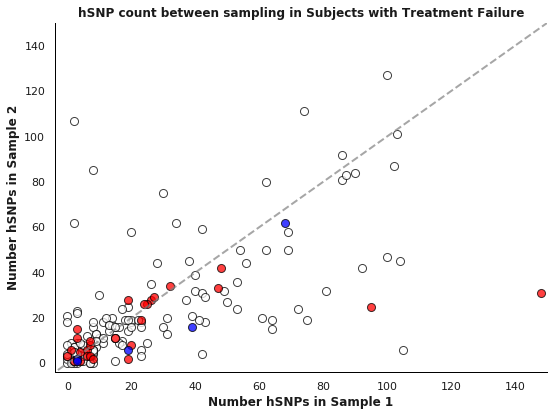

In [54]:
fig , ax = plt.subplots()

ax.plot([-3 , 173] , [-3 , 173] , color = '0.5' , linewidth = 2.0 , linestyle = '--' , alpha = 0.7)
ax.scatter( SNP_counts_delayed_df[[patient_id in other_patients for patient_id in SNP_counts_delayed_df.index]].count_1 , SNP_counts_delayed_df[[patient_id in other_patients for patient_id in SNP_counts_delayed_df.index]].count_2 , color = 'white' , edgecolor = 'black' , linewidth = 1.0 , alpha = 0.75 , s = 65)
ax.scatter( SNP_counts_delayed_df[[patient_id in patients_with_AR_fSNP for patient_id in SNP_counts_delayed_df.index]].count_1 , SNP_counts_delayed_df[[patient_id in patients_with_AR_fSNP for patient_id in SNP_counts_delayed_df.index]].count_2 , color = 'red' , edgecolor = 'black' , linewidth = 1.0 , alpha = 0.75 , s = 65)
ax.scatter( SNP_counts_delayed_df[[patient_id in patients_with_putative_host_adapt_fSNP for patient_id in SNP_counts_delayed_df.index]].count_1 , SNP_counts_delayed_df[[patient_id in patients_with_putative_host_adapt_fSNP for patient_id in SNP_counts_delayed_df.index]].count_2 , color = 'blue' , edgecolor = 'black' , linewidth = 1.0 , alpha = 0.75 , s = 65)

ax.set_xlim([-4 , 150])
ax.set_ylim([-4 , 150])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelcolor = 'k')

ax.set_ylabel('Number hSNPs in Sample 2' , fontweight = 'bold', fontsize = 12 , color = 'k')
ax.set_xlabel('Number hSNPs in Sample 1' , fontweight = 'bold', fontsize = 12 , color = 'k')
ax.set_title('hSNP count between sampling in Subjects with Treatment Failure' , fontweight = 'bold', fontsize = 12 , color = 'k')


fig = plt.gcf()
fig.set_size_inches(8.0, 6.0)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/longitudinal_SNP_analysis/SNPs_detected_I2_vs_SNPs_detected_I1.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### Median SNP count at Timepoint 1

In [55]:
np.median(SNP_counts_delayed_df.count_1)

13.5

#### Median SNP count at Timepoint 2

In [56]:
np.median(SNP_counts_delayed_df.count_2)

13.5

#### Patients labeled in red & blue

RED

In [60]:
np.median(SNP_counts_delayed_df[[patient_id in patients_with_AR_fSNP for patient_id in SNP_counts_delayed_df.index]].count_1)

15.0

In [61]:
np.median(SNP_counts_delayed_df[[patient_id in patients_with_AR_fSNP for patient_id in SNP_counts_delayed_df.index]].count_2)

11.0

In [57]:
SNP_counts_delayed_df[[patient_id in patients_with_AR_fSNP for patient_id in SNP_counts_delayed_df.index]].sort_values(by='count_1')

,time_btwn_collection,count_1,count_2,count_2_minus_1
3451,5.73,0,3,3
2523,6.77,1,6,5
1960,16.70,2,1,-1
16,6.20,3,15,12
1700,27.47,3,11,8
3673,4.83,4,1,-3
P10,2.80,4,5,1
I0000024-5,12.17,6,6,0
2307,26.20,6,3,-3
2688,5.33,7,3,-4


BLUE

In [62]:
np.median(SNP_counts_delayed_df[[patient_id in patients_with_putative_host_adapt_fSNP for patient_id in SNP_counts_delayed_df.index]].count_1)

19.0

In [63]:
np.median(SNP_counts_delayed_df[[patient_id in patients_with_putative_host_adapt_fSNP for patient_id in SNP_counts_delayed_df.index]].count_2)

6.0

In [58]:
SNP_counts_delayed_df[[patient_id in patients_with_putative_host_adapt_fSNP for patient_id in SNP_counts_delayed_df.index]].sort_values(by='count_1')

,time_btwn_collection,count_1,count_2,count_2_minus_1
P09,5.60,3,2,-1
3096,12.93,3,1,-2
P377,2.93,19,6,-13
KPS_15,17.93,39,16,-23
P000183,24.37,68,62,-6
